<a href="https://colab.research.google.com/github/Futaba-Kosuke/Tomato-Manager/blob/feature%2Fml/ml/main_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import math
import random
from PIL import Image

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

print('OK')

OK


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls 'drive/My Drive/tomato_dataset'

0  1  cp.ckpt  tomato_data.npy


In [0]:
dataset_dir = 'drive/My Drive/tomato_dataset'

In [0]:
categories = [0, 1]

X = []
Y = []

#全データ格納用配列
allfiles = []

#カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = dataset_dir + "/" + str(cat)
    files = glob.glob(image_dir + "/*.jpeg")
    for f in files:
        allfiles.append((cat, f))

print(allfiles, len(allfiles))

[(0, 'drive/My Drive/tomato_dataset/0/133.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/10.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/109.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/125.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/51.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/47.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/92.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/84.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/14.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/38.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/117.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/8.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/22.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/204.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/59.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/75.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/34.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/101.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/18.jpeg'), (0, 'drive/My Drive/tomato_dataset/0/114.jpeg'), (0, 'drive/My Drive/tomato_datase

In [0]:
#画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

#渡された画像データを読み込んでXに格納し、また、画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((150, 150))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

In [0]:
#シャッフル後、学習データと検証データに分ける
X, y = make_sample(allfiles)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
xy = (X_train, X_test, y_train, y_test)
#データを保存する（データの名前を「tomato_data.npy」としている）
#tomato_data.npyの作成（まだmlディレクトリにファイルがある）
file = open(dataset_dir + '/tomato_data.npy', 'w')
file.close()
#データの保存
np.save(dataset_dir + '/tomato_data.npy', xy)

In [0]:
import itertools

def cropping(img, x, y, px):
    cropped = cv2.resize(img[y: y+px, x: x+px, :], (150, 150))
    return cropped

def flip(img):
    flipped = cv2.flip(img, 1)
    return flipped

def preprocess(X, y):
    new_X = np.ndarray((0, 150, 150, 3),dtype=np.uint8)
    new_y = np.ndarray((0),dtype=int)
    for index, img in enumerate(X):
        

        for i, j in itertools.product(range(3), range(3)):
            cropped = cropping(img, i*4, j*4, 24)
            flipped = flip(cropped)
        
            new_X = np.concatenate([new_X, cropped.reshape(1,150,150,3), flipped.reshape(1,150,150,3)],axis=0)
            new_y = np.concatenate([new_y, y[index], y[index]],axis=0)
    
    cnt = new_X.shape[0]
    
    shuffle_array = np.arange(cnt)
    np.random.shuffle(shuffle_array)
    
    new_X = new_X[shuffle_array]
    new_y = new_y[shuffle_array]
    
    new_y = new_y.reshape(-1, 1)
            
    return new_X, new_y

In [0]:
X_train, X_test, y_train, y_test = np.load(dataset_dir + '/tomato_data.npy', allow_pickle=True)  #保存した学習データ・テストデータのパス

In [0]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train, y_train = preprocess(X_train, y_train)
# X_test, y_test = preprocess(X_test, y_test)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [0]:
#データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float")  / 255
#one-hotエンコーディング
Y_train = np.identity(2)[y_train].astype('i')
Y_test = np.identity(2)[y_test].astype('i')

In [0]:
print(type(X_train), X_train.shape)
print(type(X_test), X_test.shape)
print(type(Y_train), Y_train.shape)
print(type(Y_test), Y_test.shape)
print(Y_train, Y_test)
print(X_train.max())

<class 'numpy.ndarray'> (3690, 150, 150, 3)
<class 'numpy.ndarray'> (89, 150, 150, 3)
<class 'numpy.ndarray'> (3690, 2)
<class 'numpy.ndarray'> (89, 2)
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [0 1]
 [0 1]] [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]
1.0


[0 1]


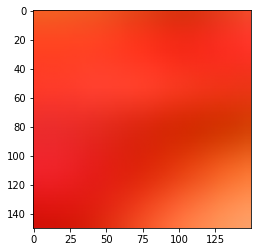

In [0]:
num = 4
plt.imshow(X_train[num])
print(Y_train[num])

In [0]:
checkpoint_path = dataset_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# チェックポイントコールバックを作る
cp_callback = ModelCheckpoint(
                                                 checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
random.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
#モデルの構築
model = Sequential()

model.add(Conv2D(filters=32,input_shape=(150,150,3), kernel_size=(3, 3), strides=(1,1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(filters=64,kernel_size=(3, 3), strides=(1,1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(filters=128,kernel_size=(3, 3), strides=(1,1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(filters=128,kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(200))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation("softmax")) #分類先の種類分設定

In [0]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
activation_145 (Activation)  (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
activation_146 (Activation)  (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 37, 37, 128)     

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

In [0]:
# 学習の開始
hist = model.fit(
           X_train,
           Y_train,
           epochs=2,
           validation_data=(X_test, Y_test),
           verbose=1,
           batch_size=500,
           callbacks=[cp_callback]
)

Train on 3690 samples, validate on 89 samples
Epoch 1/2
3690/3690 [==============================] - 8s 2ms/step - loss: 0.7120 - acc: 0.6388 - val_loss: 0.1909 - val_acc: 0.9663

Epoch 00001: saving model to drive/My Drive/tomato_dataset/cp.ckpt
Epoch 2/2
3690/3690 [==============================] - 5s 1ms/step - loss: 0.3044 - acc: 0.8740 - val_loss: 0.0050 - val_acc: 1.0000

Epoch 00002: saving model to drive/My Drive/tomato_dataset/cp.ckpt


In [0]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [0]:
print('y_train_pred: ', y_train_pred)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [[9.9979526e-01 2.0475176e-04]
 [9.9843520e-01 1.5648217e-03]
 [9.9736279e-01 2.6372168e-03]
 ...
 [9.9977499e-01 2.2501845e-04]
 [5.6481473e-03 9.9435186e-01]
 [1.4496982e-01 8.5503018e-01]]
y_test_pred:  [[5.92025404e-04 9.99408007e-01]
 [6.36198744e-03 9.93637979e-01]
 [9.98584151e-01 1.41582871e-03]
 [2.63432716e-03 9.97365654e-01]
 [9.99849916e-01 1.50120715e-04]
 [2.85118213e-03 9.97148812e-01]
 [1.67921680e-04 9.99832034e-01]
 [6.17123587e-05 9.99938250e-01]
 [9.99547541e-01 4.52394743e-04]
 [9.68455076e-01 3.15449312e-02]
 [9.98258293e-01 1.74168497e-03]
 [9.99193966e-01 8.06045602e-04]
 [3.39947350e-04 9.99660015e-01]
 [9.79700029e-01 2.02999804e-02]
 [9.98112202e-01 1.88785244e-03]
 [1.56347752e-02 9.84365225e-01]
 [9.95643377e-01 4.35662409e-03]
 [9.99849319e-01 1.50631735e-04]
 [8.80922854e-01 1.19077176e-01]
 [1.18682475e-03 9.98813152e-01]
 [9.99983072e-01 1.68980005e-05]
 [8.82120524e-03 9.91178811e-01]
 [9.98813391e-01 1.18657551e-03]
 [3.36042121e-02 9.6

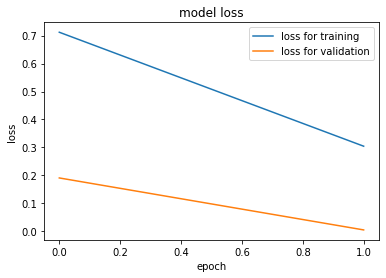

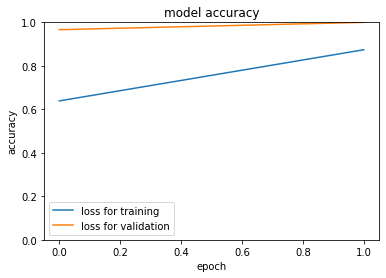

In [0]:
#学習結果を表示
def plot_history_loss(hist):
    # 損失値(Loss)の遷移のプロット
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

def plot_history_acc(hist):
    # 精度(Accuracy)の遷移のプロット
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]


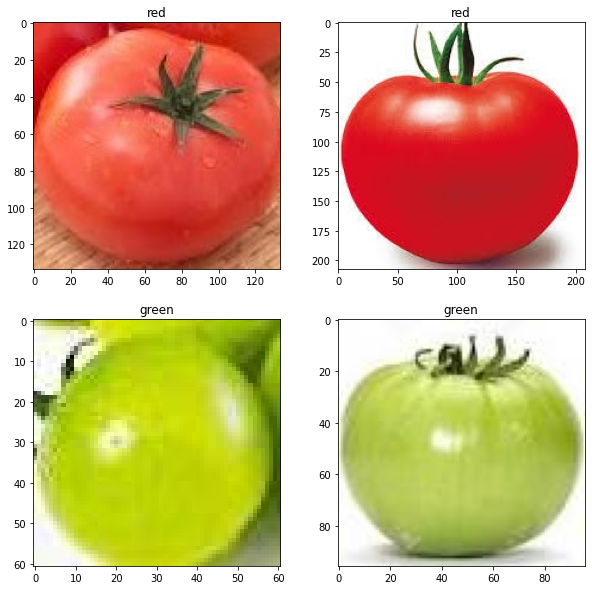

In [417]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(1, 5):
    img = cv2.imread(dataset_dir + '/test/' + str(i) + '.jpeg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    X = cv2.resize(img, (150, 150))
    X = X.astype('float') / 255

    X = X.reshape(1, 150, 150, 3)

    result = model.predict(X)
    print(np.round(result))

    if np.round(result)[0][0] == 1:
        title = 'green'
    else:
        title = 'red'

    ax[int((i-1)/2), (i-1)%2].imshow(img)
    ax[int((i-1)/2), (i-1)%2].set_title(title)